# Предобработка данных и функции потерь в линейной регрессии

## Данные
Для демонстраций загрузим набор данных [Automobile Data Set](https://archive.ics.uci.edu/ml/datasets/Automobile). В данных присутствуют категориальные, целочисленные и вещественнозначные признаки.

In [1]:
import pandas as pd

In [2]:
pd.read_csv??

In [3]:
import pandas as pd
X_raw = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.data", \
                    header=None, na_values=["?"])

In [4]:
X_raw.head(10)

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,13495.0
1,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,16500.0
2,1,NaN,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154.0,5000.0,19,26,16500.0
3,2,164.0,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102.0,5500.0,24,30,13950.0
4,2,164.0,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115.0,5500.0,18,22,17450.0
5,2,NaN,audi,gas,std,two,sedan,fwd,front,99.8,...,136,mpfi,3.19,3.40,8.5,110.0,5500.0,19,25,15250.0
6,1,158.0,audi,gas,std,four,sedan,fwd,front,105.8,...,136,mpfi,3.19,3.40,8.5,110.0,5500.0,19,25,17710.0
7,1,NaN,audi,gas,std,four,wagon,fwd,front,105.8,...,136,mpfi,3.19,3.40,8.5,110.0,5500.0,19,25,18920.0
8,1,158.0,audi,gas,turbo,four,sedan,fwd,front,105.8,...,131,mpfi,3.13,3.40,8.3,140.0,5500.0,17,20,23875.0
9,0,NaN,audi,gas,turbo,two,hatchback,4wd,front,99.5,...,131,mpfi,3.13,3.40,7.0,160.0,5500.0,16,22,NaN


In [5]:
X_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       205 non-null    int64  
 1   1       164 non-null    float64
 2   2       205 non-null    object 
 3   3       205 non-null    object 
 4   4       205 non-null    object 
 5   5       203 non-null    object 
 6   6       205 non-null    object 
 7   7       205 non-null    object 
 8   8       205 non-null    object 
 9   9       205 non-null    float64
 10  10      205 non-null    float64
 11  11      205 non-null    float64
 12  12      205 non-null    float64
 13  13      205 non-null    int64  
 14  14      205 non-null    object 
 15  15      205 non-null    object 
 16  16      205 non-null    int64  
 17  17      205 non-null    object 
 18  18      201 non-null    float64
 19  19      201 non-null    float64
 20  20      205 non-null    float64
 21  21      203 non-null    float64
 22  22

In [7]:
X_raw[25].isna().sum()

4

In [4]:
X_raw[25].notna()

0      True
1      True
2      True
3      True
4      True
       ... 
200    True
201    True
202    True
203    True
204    True
Name: 25, Length: 205, dtype: bool

In [8]:
X_raw = X_raw[X_raw[25].notna()]

In [9]:
y = X_raw[25]
X_raw = X_raw.drop(25, axis=1)

In [10]:
X_raw.shape, len(y)

((201, 25), 201)

## Предобработка данных
Предобработка данных важна при применении любых методов машинного обучения, а в особенности для линейных моделей. В sklearn предобработку удобно делать с помощью модуля [preprocessing](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing) или методов библиотеки pandas.

In [11]:
!pip install scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 21.0 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.7/29.7 MB 26.7 MB/s eta 0:00:00m eta 0:00:010:01:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 12.1 MB/s eta 0:00:00


In [12]:
from sklearn import impute

### Заполнение пропусков
В матрице объекты-признаки могут быть пропущенные значения, и это вызовет исключение при попытке передать такую матрицу в функцию обучения модели или даже предобработки. Если пропусков немного, можно удалить объекты с пропусками из обучающей выборки. Заполнить пропуски можно разными способами:
* заполнить средними (mean, median);
* предсказывать пропущенные значения по непропущенным.

Последний вариант сложный и применяется редко. Для заполнения константами можно использовать метод датафрейма fillna, для замены средними - класс preprocessing.Imputer.

In [ ]:
X_raw.fillna()

In [13]:
# для удобства работы с нашим датасетом создаем маску, указывающую на столбцы с категориальными признаками
cat_features_mask = (X_raw.dtypes == "object").values # категориальные признаки имеют тип "object"

In [14]:
# для вещественнозначных признаков заполним пропуски средними
X_real = X_raw[X_raw.columns[~cat_features_mask]]
mis_replacer = impute.SimpleImputer(strategy="mean")
X_no_mis_real = pd.DataFrame(data=mis_replacer.fit_transform(X_real), columns=X_real.columns)

# для категориальных - пустыми строками
X_cat = X_raw[X_raw.columns[cat_features_mask]].fillna("")
X_cat.reset_index(drop=True, inplace=True)

X_no_mis = pd.concat([X_no_mis_real, X_cat], axis=1)

In [15]:
X_no_mis_real.shape, X_cat.shape, X_no_mis.shape

((201, 15), (201, 10), (201, 25))

In [16]:
X_no_mis.head()

,0,1,9,10,11,12,13,16,18,19,...,2,3,4,5,6,7,8,14,15,17
0,3.0,122.0,88.6,168.8,64.1,48.8,2548.0,130.0,3.47,2.68,...,alfa-romero,gas,std,two,convertible,rwd,front,dohc,four,mpfi
1,3.0,122.0,88.6,168.8,64.1,48.8,2548.0,130.0,3.47,2.68,...,alfa-romero,gas,std,two,convertible,rwd,front,dohc,four,mpfi
2,1.0,122.0,94.5,171.2,65.5,52.4,2823.0,152.0,2.68,3.47,...,alfa-romero,gas,std,two,hatchback,rwd,front,ohcv,six,mpfi
3,2.0,164.0,99.8,176.6,66.2,54.3,2337.0,109.0,3.19,3.40,...,audi,gas,std,four,sedan,fwd,front,ohc,four,mpfi
4,2.0,164.0,99.4,176.6,66.4,54.3,2824.0,136.0,3.19,3.40,...,audi,gas,std,four,sedan,4wd,front,ohc,five,mpfi


In [17]:
X_no_mis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201 entries, 0 to 200
Data columns (total 25 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       201 non-null    float64
 1   1       201 non-null    float64
 2   9       201 non-null    float64
 3   10      201 non-null    float64
 4   11      201 non-null    float64
 5   12      201 non-null    float64
 6   13      201 non-null    float64
 7   16      201 non-null    float64
 8   18      201 non-null    float64
 9   19      201 non-null    float64
 10  20      201 non-null    float64
 11  21      201 non-null    float64
 12  22      201 non-null    float64
 13  23      201 non-null    float64
 14  24      201 non-null    float64
 15  2       201 non-null    object 
 16  3       201 non-null    object 
 17  4       201 non-null    object 
 18  5       201 non-null    object 
 19  6       201 non-null    object 
 20  7       201 non-null    object 
 21  8       201 non-null    object 
 22  14

Всегда нужно осознавать, случайны ли пропуски в каком-то признаке. Иногда факт отсутствия информации о значении признака может сам быть важным признаком, который необходимо добавить к другим признакам.

__Пример:__ предсказание возраста пользователя по данным с его телефона. Поскольку люди старшего возраста чаще пользуются простыми телефонами, факт отсутствия каких-то данных (например, истории посещенных интернет-страниц), скорее всего, будет хорошим признаком.

Для категориальных признаков рекомендуется создавать отдельную категорию, соответствующую пропущенному значению. В наши данных пропусков в категориальных признаках нет.

### Преобразование нечисловых признаков
Практически все методы машинного обучения требуют, чтобы на вход функции обучения подавалась вещественная матрица. В процессе обучения используются свойства вещественных чисел, в частности, возможность сравнения и применения арифметических операций. Поэтому, даже если формально в матрице объекты-признаки записаны числовые значения, нужно всегда анализировать, можно ли относиться к ним как к числам. 

__Пример:__ некоторые признаки могут задаваться целочисленными хешами или id (например, id пользователя соц. сети), однако нельзя сложить двух пользователей и получить третьего, исходя из их id (как это может сделать линейная модель).

Это пример категориального признака, принимающего значения из неупорядоченного конечного множества $K$. К таким признакам обычно применяют [one-hot encoding](http://scikit-learn.org/stable/modules/preprocessing.html#encoding-categorical-features) (вместо одного признака создают $K$ бинарных признаков - по одному на каждое возможное значение исходного признака). В sklearn это можно сделать с помощью классов LabelEncoder + OneHotEncoding, но проще использовать функцию pd.get_dummies.

Следует заметить, что в новой матрице будет очень много нулевых значений. Чтобы не хранить их в памяти, можно задать параметр OneHotEncoder(sparse = True) или .get_dummies(sparse=True), и метод вернет [разреженную матрицу](http://docs.scipy.org/doc/scipy/reference/sparse.html), в которой хранятся только ненулевые значения. Выполнение некоторых операций с такой матрицей может быть неэффективным, однако большинство методов sklearn умеют работать с разреженными матрицами.

__Вопрос:__ какая проблема возникнет при применении такого способа кодирования для обучения линейной регрессии?
    
Необходимо удалить один из столбцов, созданных для каждого признака. Для этого в get_dummies надо поставить drop_first=True.

In [19]:
X_dum = pd.get_dummies(X_no_mis, drop_first=True)
print(X_dum.shape)
X_dum.head()

(201, 65)


,0,1,9,10,11,12,13,16,18,19,...,15_three,15_twelve,15_two,17_2bbl,17_4bbl,17_idi,17_mfi,17_mpfi,17_spdi,17_spfi
0,3.0,122.0,88.6,168.8,64.1,48.8,2548.0,130.0,3.47,2.68,...,False,False,False,False,False,False,False,True,False,False
1,3.0,122.0,88.6,168.8,64.1,48.8,2548.0,130.0,3.47,2.68,...,False,False,False,False,False,False,False,True,False,False
2,1.0,122.0,94.5,171.2,65.5,52.4,2823.0,152.0,2.68,3.47,...,False,False,False,False,False,False,False,True,False,False
3,2.0,164.0,99.8,176.6,66.2,54.3,2337.0,109.0,3.19,3.40,...,False,False,False,False,False,False,False,True,False,False
4,2.0,164.0,99.4,176.6,66.4,54.3,2824.0,136.0,3.19,3.40,...,False,False,False,False,False,False,False,True,False,False


Помимо категориальных, преобразования требуют, например, строковые признаки. Их можно превращать в матрицу частот слов [CountVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer), матрицу частот буквосочетаний фиксированной длины, можно извлекать другие признаки (например, длина строки).

### Масштабирование признаков
При начале работы с данными всегда рекомендуется приводить все признаки к одному масштабу.  Это важно по нескольким причинам:
* ускорение обучения модели (пояснение на лекции);
* улучшение численной устойчивости при работе с матрицей объекты-признаки (рядом с нулем чисел с плавающей точкой больше, чем с области больших чисел)
* для линейных моделей: интерпретация весов при признаках как меры их значимости.

Первый популярный способ масштабирования - нормализация: вычитание среднего из каждого признака и деление на стандартное отклонение (StandardScaler в sklearn). Второй популярный способ: вычитание минимума из каждого признака, а затем деление на разницу максимального и минимального значения (MinMaxScaler в sklearn).

In [20]:
X_dum

,0,1,9,10,11,12,13,16,18,19,...,15_three,15_twelve,15_two,17_2bbl,17_4bbl,17_idi,17_mfi,17_mpfi,17_spdi,17_spfi
0,3.0,122.0,88.6,168.8,64.1,48.8,2548.0,130.0,3.47,2.68,...,False,False,False,False,False,False,False,True,False,False
1,3.0,122.0,88.6,168.8,64.1,48.8,2548.0,130.0,3.47,2.68,...,False,False,False,False,False,False,False,True,False,False
2,1.0,122.0,94.5,171.2,65.5,52.4,2823.0,152.0,2.68,3.47,...,False,False,False,False,False,False,False,True,False,False
3,2.0,164.0,99.8,176.6,66.2,54.3,2337.0,109.0,3.19,3.40,...,False,False,False,False,False,False,False,True,False,False
4,2.0,164.0,99.4,176.6,66.4,54.3,2824.0,136.0,3.19,3.40,...,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,-1.0,95.0,109.1,188.8,68.9,55.5,2952.0,141.0,3.78,3.15,...,False,False,False,False,False,False,False,True,False,False
197,-1.0,95.0,109.1,188.8,68.8,55.5,3049.0,141.0,3.78,3.15,...,False,False,False,False,False,False,False,True,False,False
198,-1.0,95.0,109.1,188.8,68.9,55.5,3012.0,173.0,3.58,2.87,...,False,False,False,False,False,False,False,True,False,False
199,-1.0,95.0,109.1,188.8,68.9,55.5,3217.0,145.0,3.01,3.40,...,False,False,False,False,False,True,False,False,False,False


In [21]:
X_dum.columns = X_dum.columns.astype('str')

In [22]:
X_dum.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201 entries, 0 to 200
Data columns (total 65 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   0                201 non-null    float64
 1   1                201 non-null    float64
 2   9                201 non-null    float64
 3   10               201 non-null    float64
 4   11               201 non-null    float64
 5   12               201 non-null    float64
 6   13               201 non-null    float64
 7   16               201 non-null    float64
 8   18               201 non-null    float64
 9   19               201 non-null    float64
 10  20               201 non-null    float64
 11  21               201 non-null    float64
 12  22               201 non-null    float64
 13  23               201 non-null    float64
 14  24               201 non-null    float64
 15  2_audi           201 non-null    bool   
 16  2_bmw            201 non-null    bool   
 17  2_chevrolet     

In [24]:
from sklearn import preprocessing

normalizer = preprocessing.MinMaxScaler()
X_real_norm_np = normalizer.fit_transform(X_dum)
X = pd.DataFrame(data=X_real_norm_np)

In [25]:
preprocessing.StandardScaler()

StandardScaler()

In [26]:
X.head()

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,64
0,1.0,0.298429,0.058309,0.413433,0.324786,0.083333,0.411171,0.260377,0.664286,0.290476,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.0,0.298429,0.058309,0.413433,0.324786,0.083333,0.411171,0.260377,0.664286,0.290476,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.6,0.298429,0.230321,0.449254,0.444444,0.383333,0.517843,0.343396,0.100000,0.666667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.8,0.518325,0.384840,0.529851,0.504274,0.541667,0.329325,0.181132,0.464286,0.633333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.8,0.518325,0.373178,0.529851,0.521368,0.541667,0.518231,0.283019,0.464286,0.633333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


### Обучение модели и оценка качества

In [27]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.25, random_state=123)

In [30]:
ytrain

115    16630.0
43      6785.0
197    16515.0
196    15985.0
110    13860.0
        ...   
18      5151.0
101    13499.0
69     28176.0
130     9295.0
112    16900.0
Name: 25, Length: 150, dtype: float64

Сначала обучим классическую линейную регрессию, работающую по аналитической формуле.

In [32]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

model.fit(Xtrain, ytrain)

LinearRegression()

In [33]:
pred_mse = model.predict(Xtest)

In [34]:
from sklearn.metrics import 

r2_score(ytest, pred_mse)

0.772139628678113

In [35]:
r2_score(ytrain, model.predict(Xtrain))

0.9757673647739797

In [36]:
ytrain.shape

(150,)

In [37]:
r2_score(ytrain, [ytrain.mean()]*ytrain.shape[0])

0.0

Сильно переобучились.

Добавим регуляризацию:

*  L1-регуляризация: Lasso
*  L2-регуляризация: Ridge
*  L1+L2: ElasticNet

In [47]:
from sklearn.linear_model import Ridge

model_l2 = Ridge(alpha=1)

model_l2.fit(Xtrain, ytrain)

pred_l2 = model_l2.predict(Xtest)

r2_score(ytest, pred_l2)

0.8315766274428084

In [45]:
from sklearn.linear_model import Lasso

model_l1 = Lasso(alpha=3.5)

model_l1.fit(Xtrain, ytrain)

pred_l1 = model_l1.predict(Xtest)

r2_score(ytest, pred_l1)

0.8211820607770746

In [53]:
from sklearn.linear_model import ElasticNet

model_l2 = ElasticNet(alpha=0.5, l1_ratio=0)

model_l2.fit(Xtrain, ytrain)

pred_l2 = model_l2.predict(Xtest)

r2_score(ytest, pred_l2)

/Users/aarysmyatova/miniconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.521e+09, tolerance: 1.041e+06 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


0.43902281937096044

In [50]:
ytrain

115    16630.0
43      6785.0
197    16515.0
196    15985.0
110    13860.0
        ...   
18      5151.0
101    13499.0
69     28176.0
130     9295.0
112    16900.0
Name: 25, Length: 150, dtype: float64

In [46]:
model_l1.coef_

array([   -0.        , -4678.74432468,  2640.87238376, -2483.31738667,
        7705.51127902, -2514.91401517, 14856.48358703, 16556.50974328,
       -3257.15632461, -1858.15953361,    -0.        ,  2281.30672238,
        4212.11495416,    -0.        ,  3847.46517895,  4087.90212444,
        7500.33951851,  -865.23772694, -1088.62862203,     0.        ,
       -2382.39243814,  2391.24236446,   248.06899447,  3882.6897738 ,
           0.        , -1827.13211867,  -531.94729711, -2110.73398692,
       -1304.93580515, 13799.90777383,  -842.42365247,  2668.68498603,
          -0.        , -1770.0437185 ,   101.79414941, -1623.87170897,
         -50.67688899,  2248.68461029,  -278.10132443,     0.        ,
       -3171.19696779, -2445.13919958, -1758.46674971, -2766.45416663,
        -657.74750016,  2160.71502431,   289.70867306,    -0.        ,
         987.95480089,   204.90743967, -1769.92037457,   828.32994417,
       -5159.08512391, -3263.13321299, -2875.18208381,  1339.31940036,
      

In [54]:
model_l2.coef_

array([  -44.08247388,    25.47103765,   633.10785973,   798.67526678,
         948.87584294,    58.39820474,  1133.17928594,  1057.92978111,
         667.34625686,   162.05745983,    91.47415943,  1051.17864307,
         -85.7093476 ,  -792.11768118,  -805.48928823,   114.87616534,
         600.76292011,   -64.56635483,   -90.77839007,  -221.73923466,
        -123.3716728 ,   441.39943296,  -131.04992826,   915.57514486,
           0.        ,  -124.62865456,  -387.03958968,  -190.97546748,
        -128.35195981,   505.65149651,   -72.07933304,    92.7469086 ,
        -314.97186915,  -615.01333665,  -161.2398629 ,    25.27204328,
        -188.75616718,   475.64333513,    -8.31143895,    22.48725242,
         308.78107129,  -865.88343606,   551.93921941,  -360.65768129,
       -1544.11541261,  1651.34558395,   505.65149651,  -236.40543806,
        -441.82985775,   190.67962736,   438.38896334,   -55.89380591,
         477.73810153, -2081.54241706,   995.2237902 ,   -45.42997057,
      

In [40]:
model_l2.intercept_

8685.911220016162

In [36]:
r2_score(ytrain, model_l2.predict(Xtrain))

0.9533372216376615

Переобучение снизили!

Можно обучать регрессию градиентным спуском.

In [60]:
from sklearn.linear_model import SGDRegressor

lr_mse = SGDRegressor(loss='squared_error')

lr_mse.fit(Xtrain, ytrain)

pred_mse = lr_mse.predict(Xtest)

r2_score(ytest, pred_mse)

0.8230853557325266

А можно использовать не MSE, а MAE при обучении модели.

In [86]:
lr_mae = SGDRegressor(loss='epsilon_insensitive', epsilon=0, eta0=0.9)

lr_mae.fit(Xtrain, ytrain)

pred_mae = lr_mae.predict(Xtest)

r2_score(ytest, pred_mae)

/Users/aarysmyatova/miniconda3/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:1561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


0.41586815172713587

### Бонус: cреднеквадратичная и средняя абсолютная ошибка
Кроме требований заказчика, функционал качества должен учитывать математические особенности модели, например устойчивость к шумовым объектам. В линейной регрессии Mean Squared Error: $L(y_i, a(x_i)) = (a(x_i) - y_i)^2$ не обладает этим свойством, потому что задает очень большие штрафы за большие отклонения от фактического значения. 

Рассмотрим это явление на примере. Выберем один признак, от которого целевой признак (имеющий индекс 15 в матрице X) зависит практически линейно. Добавим к выборке два объекта-выброса и посмотрим, как изменится оптимизированная на MSE прямая.

In [67]:
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression as LR
import numpy as np

In [68]:
X[15].values

array([0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [69]:
X_subset = X[[7, 15]].values
X_subset_modified = np.vstack((X_subset, [[1, 90], [2, 50]])) # добавление двух шумовых точек

In [70]:
X_subset

array([[0.26037736, 0.        ],
       [0.26037736, 0.        ],
       [0.34339623, 0.        ],
       [0.18113208, 1.        ],
       [0.28301887, 1.        ],
       [0.28301887, 1.        ],
       [0.28301887, 1.        ],
       [0.28301887, 1.        ],
       [0.26415094, 1.        ],
       [0.17735849, 0.        ],
       [0.17735849, 0.        ],
       [0.38867925, 0.        ],
       [0.38867925, 0.        ],
       [0.38867925, 0.        ],
       [0.55849057, 0.        ],
       [0.55849057, 0.        ],
       [0.55849057, 0.        ],
       [0.        , 0.        ],
       [0.10943396, 0.        ],
       [0.10943396, 0.        ],
       [0.10943396, 0.        ],
       [0.10943396, 0.        ],
       [0.13962264, 0.        ],
       [0.10943396, 0.        ],
       [0.10943396, 0.        ],
       [0.10943396, 0.        ],
       [0.13962264, 0.        ],
       [0.23018868, 0.        ],
       [0.35849057, 0.        ],
       [0.11698113, 0.        ],
       [0.

In [71]:
def scatter_points_and_plot_line_MSE(X_subset):
    plt.scatter(X_subset[:, 0], X_subset[:, 1])   # визуализируем точки
    lr = LR()
    lr.fit(X_subset[:, 0][:, np.newaxis], X_subset[:, 1])  # найдем веса линейной модели
    grid = np.linspace(0, 2, 100)
    line = lr.predict(grid[:, np.newaxis])
    plt.plot(grid, line)   # визуализируем прямую

Text(0.5, 0, 'x')

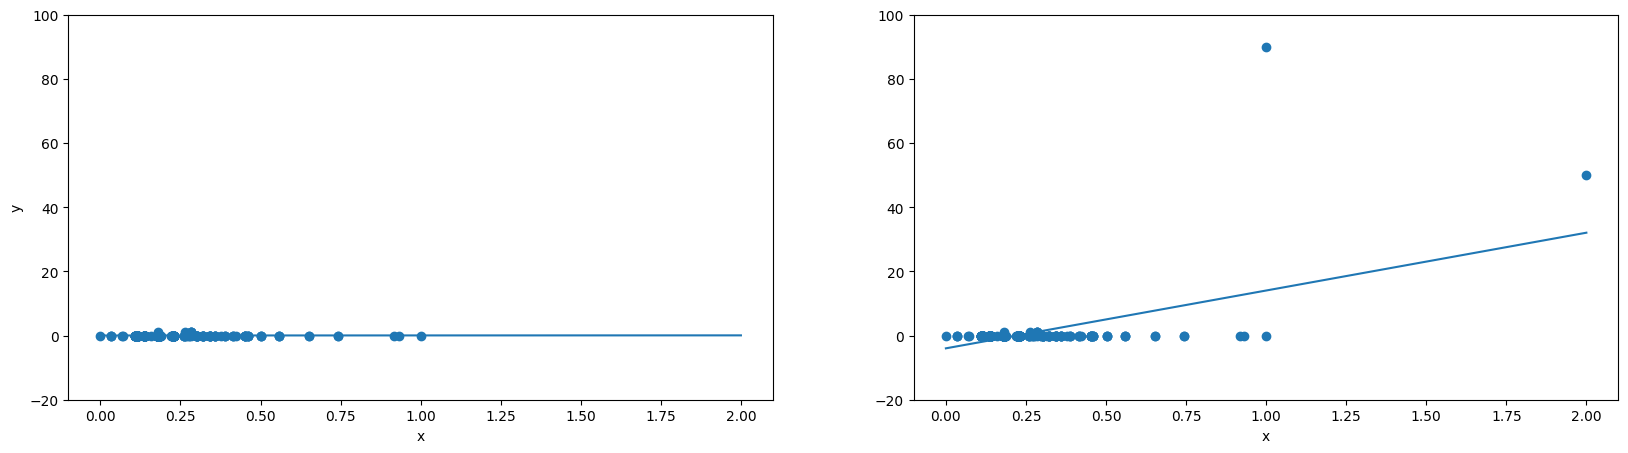

In [72]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
scatter_points_and_plot_line_MSE(X_subset)
plt.ylim(-20, 100)
plt.xlabel("x")
plt.ylabel("y")
plt.subplot(1, 2, 2)
scatter_points_and_plot_line_MSE(X_subset_modified)
plt.ylim(-20, 100)
plt.xlabel("x")

Из-за шумовых объектов прямая достаточно сильно изменила наклон. Поэтому вместо MSE часто используют Mean Absoulte Error: $L(y_i, a(x_i)) = |a(x_i) - y_i|$:

Теперь обучим регрессию, оптимизируя MAE. В sklearn такая регрессия не реализована, но можно использовать модуль statsmodels

In [51]:
!pip install statsmodels

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 19.3 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.8/233.8 kB 18.0 MB/s eta 0:00:00


In [73]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [74]:
def scatter_points_and_plot_line_MAE(X_subset):
    mod = smf.quantreg('f15 ~ f7', pd.DataFrame(data=X_subset, columns=["f7", "f15"])) # задаем зависимость и передаем данные
    res = mod.fit(q=0.5)
    plt.scatter(X_subset[:, 0], X_subset[:, 1])   # визуализируем точки
    grid = np.linspace(0, 2, 100)
    plt.plot(grid, grid * res.params["f7"] + res.params["Intercept"])   # визуализируем прямую
    return mod, res

/Users/aarysmyatova/miniconda3/lib/python3.11/site-packages/statsmodels/regression/quantile_regression.py:206: RuntimeWarning: divide by zero encountered in scalar divide
  d = np.where(e > 0, (q/fhat0)**2, ((1-q)/fhat0)**2)
/Users/aarysmyatova/miniconda3/lib/python3.11/site-packages/statsmodels/regression/quantile_regression.py:208: RuntimeWarning: invalid value encountered in multiply
  xtdx = np.dot(exog.T * d[np.newaxis, :], exog)
/Users/aarysmyatova/miniconda3/lib/python3.11/site-packages/statsmodels/regression/quantile_regression.py:219: RuntimeWarning: divide by zero encountered in scalar divide
  lfit.sparsity = 1. / fhat0


Text(0.5, 0, 'x')

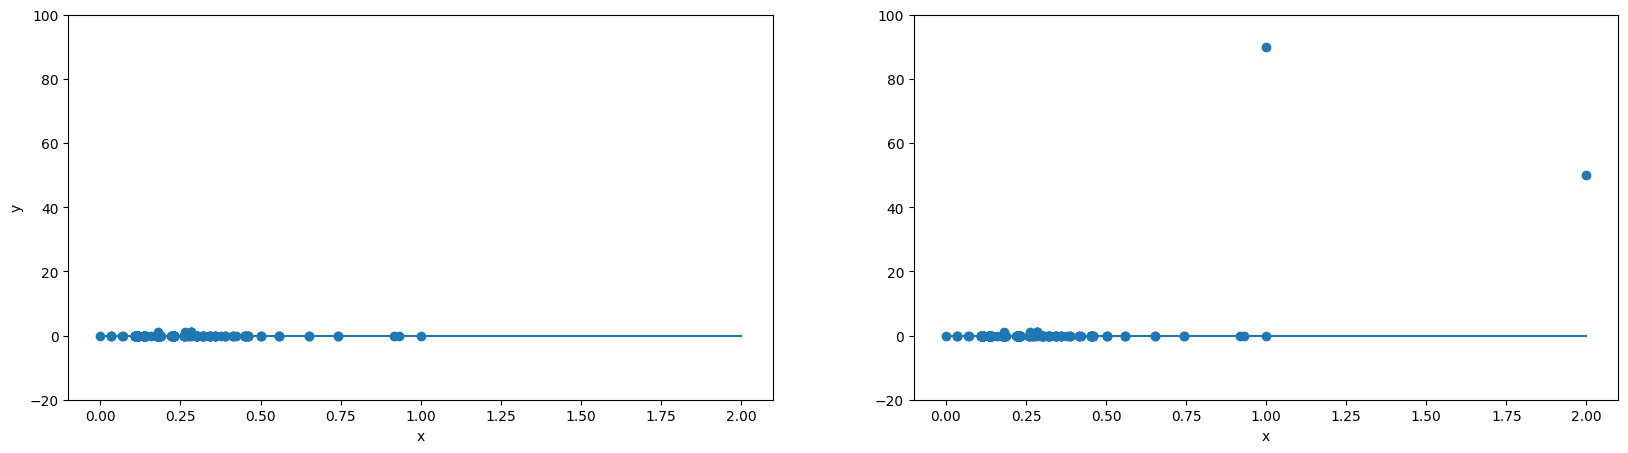

In [75]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
model, result = scatter_points_and_plot_line_MAE(X_subset)
plt.ylim(-20, 100)
plt.xlabel("x")
plt.ylabel("y")
plt.subplot(1, 2, 2)
model, result = scatter_points_and_plot_line_MAE(X_subset_modified)
plt.ylim(-20, 100)
plt.xlabel("x")

Прямая не изменила направление из-за выбросов.

Попробуем добавить больше шумовых объектов:

In [76]:
X_subset_modified_twice = np.vstack((X_subset_modified, np.random.randint(5, size=60).reshape(-1, 2)*[1, 30])) # добавление двух шумовых точек

/Users/aarysmyatova/miniconda3/lib/python3.11/site-packages/statsmodels/regression/quantile_regression.py:206: RuntimeWarning: divide by zero encountered in scalar divide
  d = np.where(e > 0, (q/fhat0)**2, ((1-q)/fhat0)**2)
/Users/aarysmyatova/miniconda3/lib/python3.11/site-packages/statsmodels/regression/quantile_regression.py:208: RuntimeWarning: invalid value encountered in multiply
  xtdx = np.dot(exog.T * d[np.newaxis, :], exog)
/Users/aarysmyatova/miniconda3/lib/python3.11/site-packages/statsmodels/regression/quantile_regression.py:219: RuntimeWarning: divide by zero encountered in scalar divide
  lfit.sparsity = 1. / fhat0


Text(0.5, 0, 'x')

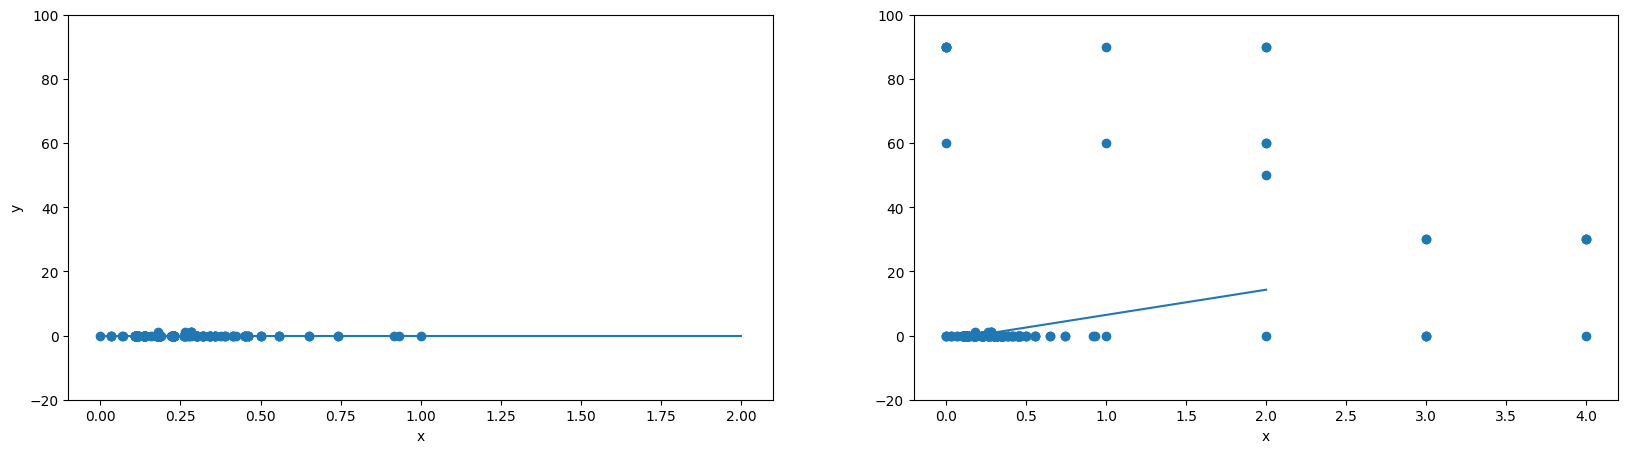

In [77]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
model, result = scatter_points_and_plot_line_MAE(X_subset)
plt.ylim(-20, 100)
plt.xlabel("x")
plt.ylabel("y")
plt.subplot(1, 2, 2)
model, result = scatter_points_and_plot_line_MAE(X_subset_modified_twice)
plt.ylim(-20, 100)
plt.xlabel("x")

Прямая изменила наклон, когда мы добавили 30 (почти 15%) шумовых точек.